#### În cadrul proiectului s-a utilizat setul de date [Travel Insurance](https://www.kaggle.com/datasets/mhdzahier/travel-insurance?fbclid=IwAR1899xlR4QHP7uZxyKlO-eACSOZIj102JBuj03vMxkcTYvAnYdDkJqow9M). Cu ajutorul acestuia se vor imparti in categorii datele pentru cazul in care despagubirile in urma asigurarii de calatorie au fost acordate sau nu.
<br/>

#### Descrierea setului de date:


*   **Claim**, coloana target, cu valorile *Yes* sau *No*, dacă despagubirea a fost acordata sau nu a fost acordata
*   **Agency**, numele agentiei alese pentru a realiza asigurarea
*   **Agency Type** tipul agentiei la care s-a facut asigurarea de calatorie
*   **Distribution Channel** modalitatea prin care a fost achizitionata asigurarea, *Online* sau *Offline*
*   **Product Name** numele produsului solicitat
*   **Duration** durata calatoriei
*   **Destination** destinatia calatoriei
*   **Net Sales** Valoarea vânzărilor de polițe de asigurare de călătorie 
*   **Commission** comisionul perceput de agentie in urma asigurarii
*   **Gender** genul persoanei care a solicitat asigurarea
*   **Age** varsta persoanei care a solicitat asigurarea



### 1. Incarcarea setului de date

In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
spark = SparkSession.builder.appName('travel_insurance').getOrCreate()

Vom incarca datele din fisier in obiectul de tip DataFrame, dupa care vom afisa schema datelor primele 10 inregistrari pentru a avea o privire de ansamblu asupra modului in care sunt prezentate datele.


In [4]:
import pyspark.sql.types as tp


data_folder = "/content/drive/MyDrive/big_data_files/"

data = spark.read.csv(data_folder + "travel_insurance.csv", inferSchema=True, header=True)

###2. Explorarea datelor

In [5]:
data.printSchema()

root
 |-- Agency: string (nullable = true)
 |-- Agency Type: string (nullable = true)
 |-- Distribution Channel: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Claim: string (nullable = true)
 |-- Duration: integer (nullable = true)
 |-- Destination: string (nullable = true)
 |-- Net Sales: double (nullable = true)
 |-- Commision (in value): double (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)



In [6]:
pd.DataFrame(data.take(10), columns = data.columns).transpose()

,0,1,2,3,4,5,6,7,8,9
Agency,CBH,CBH,CWT,CWT,CWT,JZI,CWT,CWT,CWT,CWT
Agency Type,Travel Agency,Travel Agency,Travel Agency,Travel Agency,Travel Agency,Airlines,Travel Agency,Travel Agency,Travel Agency,Travel Agency
Distribution Channel,Offline,Offline,Online,Online,Online,Online,Online,Online,Online,Online
Product Name,Comprehensive Plan,Comprehensive Plan,Rental Vehicle Excess Insurance,Rental Vehicle Excess Insurance,Rental Vehicle Excess Insurance,Value Plan,Rental Vehicle Excess Insurance,Rental Vehicle Excess Insurance,Rental Vehicle Excess Insurance,Rental Vehicle Excess Insurance
Claim,No,No,No,No,No,No,No,No,No,No
Duration,186,186,65,60,79,66,47,63,57,186
Destination,MALAYSIA,MALAYSIA,AUSTRALIA,AUSTRALIA,ITALY,UNITED STATES,UNITED STATES,AUSTRALIA,THAILAND,AUSTRALIA
Net Sales,-29.0,-29.0,-49.5,-39.6,-19.8,-121.0,-39.6,-108.9,-19.8,-99.0
Commision (in value),9.57,9.57,29.7,23.76,11.88,42.35,23.76,65.34,11.88,59.4
Gender,F,F,None,None,None,F,None,None,None,None


Se observa faptul ca schema a fost dedusa corect, insa dorim sa schimbam denumirile coloanelor pentru usurinta utilizarii lor in viitor.

In [7]:
data = data.withColumnRenamed("Agency Type","Agency_Type") \
           .withColumnRenamed("Distribution Channel", "Distribution_Channel") \
           .withColumnRenamed("Product Name", "Product_Name") \
           .withColumnRenamed("Net Sales", "Net_Sales") \
           .withColumnRenamed("Commision (in value)", "Commission")

Determinam dimensiunea setului de date:

In [8]:
(data.count(), len(data.columns))

(63326, 11)

Afisam descrierea coloanelor numerice din setul de date:




In [9]:
data.select('Duration', 'Net_Sales', 'Commission', 'Age').describe().show()

+-------+------------------+------------------+-----------------+------------------+
|summary|          Duration|         Net_Sales|       Commission|               Age|
+-------+------------------+------------------+-----------------+------------------+
|  count|             63326|             63326|            63326|             63326|
|   mean| 49.31707355588542|40.702017970502204|9.809991788523527|39.969980734611376|
| stddev|101.79156617721215| 48.84563729289582|19.80438849937355|14.017009538046246|
|    min|                -2|            -389.0|              0.0|                 0|
|    max|              4881|             810.0|            283.5|               118|
+-------+------------------+------------------+-----------------+------------------+



Verificam prezenta valorilor nule:


In [10]:
import pyspark.sql.functions as f

# Valorile null din fiecare coloană
data_agg = data.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in data.columns])
data_agg.show()

+------+-----------+--------------------+------------+-----+--------+-----------+---------+----------+------+---+
|Agency|Agency_Type|Distribution_Channel|Product_Name|Claim|Duration|Destination|Net_Sales|Commission|Gender|Age|
+------+-----------+--------------------+------------+-----+--------+-----------+---------+----------+------+---+
|     0|          0|                   0|           0|    0|       0|          0|        0|         0| 45107|  0|
+------+-----------+--------------------+------------+-----+--------+-----------+---------+----------+------+---+



Se observa ca singurele valori nule sunt prezente in cadrul coloanei *Gender*, fiind 45107 de valori nule din 63326 de inregistrari. Datorita procentului mare pe care acestea il ocupa, cat si faptului ca genul unei persoane nu ar trebui sa influenteze rezultatele finale, vom elimina coloana in cauza.

In [11]:
data = data.drop('Gender')

Obtinerea numarului de valori distincte de pe fiecare coloana:

In [12]:
from pyspark.sql.functions import col, countDistinct
data.agg(*(countDistinct(col(c)).alias(c) for c in data.columns)).show()

+------+-----------+--------------------+------------+-----+--------+-----------+---------+----------+---+
|Agency|Agency_Type|Distribution_Channel|Product_Name|Claim|Duration|Destination|Net_Sales|Commission|Age|
+------+-----------+--------------------+------------+-----+--------+-----------+---------+----------+---+
|    16|          2|                   2|          26|    2|     455|        149|     1139|      1035| 89|
+------+-----------+--------------------+------------+-----+--------+-----------+---------+----------+---+




In continuare vom analiza valorile corespunzatoare fiecarei coloane:


In [13]:
data.createOrReplaceTempView("travel_insurance")

### Claim

Observam ca setul de date este *imbalanced*, avand mult mai multe inregistrari in cazul negativ *No*, fata de *Yes*.

+-----+----------------+
|Claim|Number_of_claims|
+-----+----------------+
|   No|           62399|
|  Yes|             927|
+-----+----------------+



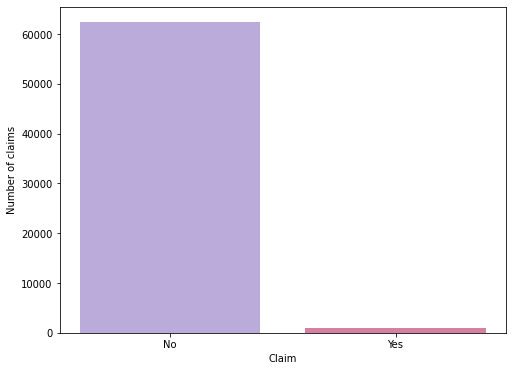

In [14]:
spark.sql("SELECT Claim, COUNT(*) as Number_of_claims FROM travel_insurance GROUP BY Claim").show()

data_plot = data.toPandas()
claim = data_plot["Claim"].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(claim.index.astype('str'), claim, color=['#BAABDA', '#D77FA1'])
plt.xlabel("Claim")
plt.ylabel("Number of claims")
plt.show()

### Agency

+------+--------------------+
|Agency|Number_of_insurances|
+------+--------------------+
|   EPX|               35119|
|   CWT|                8580|
|   C2B|                8267|
|   JZI|                6329|
|   SSI|                1056|
|   JWT|                 749|
|   RAB|                 725|
|   LWC|                 689|
|   TST|                 528|
|   KML|                 392|
|   ART|                 331|
|   CCR|                 194|
|   CBH|                 101|
|   TTW|                  98|
|   CSR|                  86|
|   ADM|                  82|
+------+--------------------+



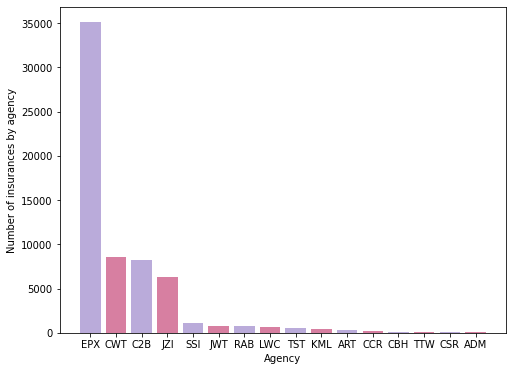

In [15]:
spark.sql("SELECT Agency, COUNT(*) as Number_of_insurances FROM travel_insurance GROUP BY Agency SORT BY Number_of_insurances DESC").show()

agency = data_plot["Agency"].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(agency.index.astype('str'), agency, color=['#BAABDA', '#D77FA1'])
plt.xlabel("Agency")
plt.ylabel("Number of insurances by agency")
plt.show()

###Agency Type

+-------------+--------------------+
|  Agency_Type|Number_of_insurances|
+-------------+--------------------+
|Travel Agency|               45869|
|     Airlines|               17457|
+-------------+--------------------+



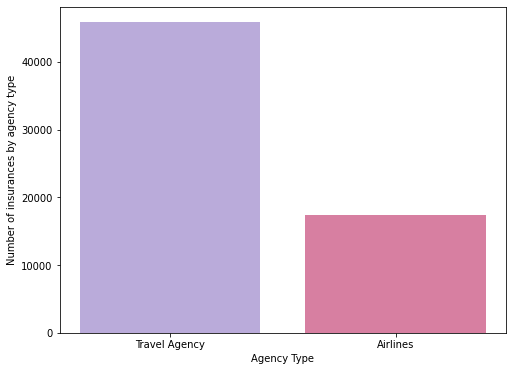

In [16]:
spark.sql("SELECT Agency_Type, COUNT(*) as Number_of_insurances FROM travel_insurance GROUP BY Agency_Type SORT BY Number_of_insurances DESC").show()

agency_type = data_plot["Agency_Type"].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(agency_type.index.astype('str'), agency_type, color=['#BAABDA', '#D77FA1'])
plt.xlabel("Agency Type")
plt.ylabel("Number of insurances by agency type")
plt.show()

### Distribution Channel

+--------------------+--------------------+
|Distribution_Channel|Number_of_insurances|
+--------------------+--------------------+
|              Online|               62219|
|             Offline|                1107|
+--------------------+--------------------+



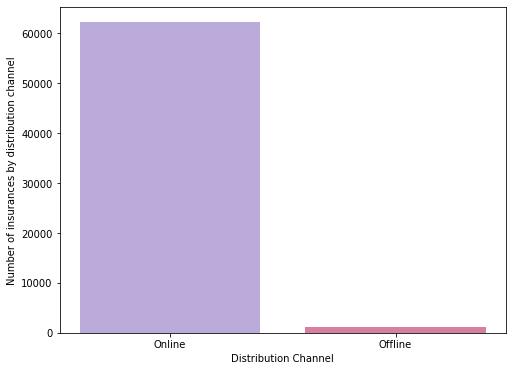

In [17]:
spark.sql("SELECT Distribution_Channel, COUNT(*) as Number_of_insurances FROM travel_insurance GROUP BY Distribution_Channel SORT BY Number_of_insurances DESC").show()

distribution_channel = data_plot["Distribution_Channel"].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(distribution_channel.index.astype('str'), distribution_channel, color=['#BAABDA', '#D77FA1'])
plt.xlabel("Distribution Channel")
plt.ylabel("Number of insurances by distribution channel")
plt.show()

Din tabelul ce contine numararea valorilor distincte pentru fiecare coloana, rezulta ca *Product Name* si *Destination* sunt categoriile care contin cele mai multe valori distincte - 26, respectiv 149 - astfel ca vom afisa doar un piechart cu primele 10 produse si destinatii selectate de persoanele asigurate.

###Product Name

+--------------------+--------------------+
|        Product_Name|Number_of_insurances|
+--------------------+--------------------+
|   Cancellation Plan|               18630|
|2 way Comprehensi...|               13158|
|Rental Vehicle Ex...|                8580|
|          Basic Plan|                5469|
|         Bronze Plan|                4049|
|1 way Comprehensi...|                3331|
|          Value Plan|                2715|
|         Silver Plan|                2249|
|  Annual Silver Plan|                1423|
|    Ticket Protector|                1056|
|Travel Cruise Pro...|                 527|
|  Comprehensive Plan|                 364|
|           Gold Plan|                 352|
|          24 Protect|                 247|
|Single Trip Trave...|                 204|
|        Premier Plan|                 194|
|    Annual Gold Plan|                 194|
|Single Trip Trave...|                 173|
|Annual Travel Pro...|                 100|
|Annual Travel Pro...|          

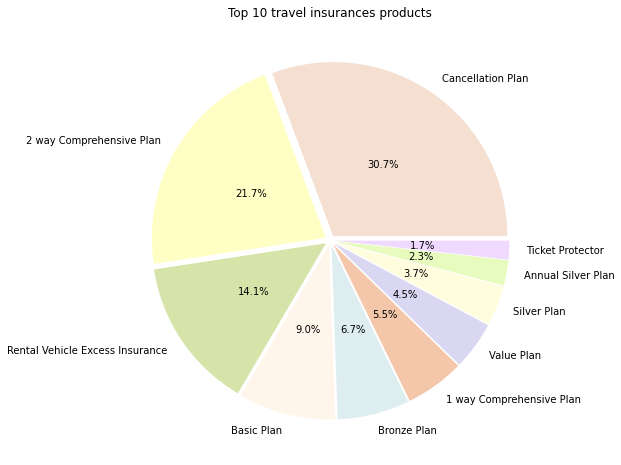

In [18]:
product_name = spark.sql("SELECT Product_Name, COUNT(*) as Number_of_insurances FROM travel_insurance GROUP BY Product_Name SORT BY Number_of_insurances DESC")
product_name.show()
product_name = product_name.toPandas().head(10)
plt.figure(figsize=(10, 8))
labels = product_name['Product_Name']
plt.pie(x=product_name['Number_of_insurances'], autopct="%.1f%%", explode=[0.03]*10, labels=labels, pctdistance=0.5, colors=['#F4DFD0', '#FFFFC5', '#D6E4AA', '#FFF5EB', '#DEEDF0', '#F4C7AB', '#D9D7F1', '#FFFDDE', '#E7FBBE', '#F0D9FF'])
plt.title('Top 10 travel insurances products')
plt.show()

###Destination

+--------------------+--------------------+
|         Destination|Number_of_insurances|
+--------------------+--------------------+
|           SINGAPORE|               13255|
|            MALAYSIA|                5930|
|            THAILAND|                5894|
|               CHINA|                4796|
|           AUSTRALIA|                3694|
|           INDONESIA|                3452|
|       UNITED STATES|                2530|
|         PHILIPPINES|                2490|
|           HONG KONG|                2411|
|               INDIA|                2251|
|               JAPAN|                2061|
|            VIET NAM|                1669|
|  KOREA, REPUBLIC OF|                1479|
|      UNITED KINGDOM|                1309|
|TAIWAN, PROVINCE ...|                1090|
|             MYANMAR|                 806|
|   BRUNEI DARUSSALAM|                 780|
|         NEW ZEALAND|                 537|
|              CANADA|                 528|
|            CAMBODIA|          

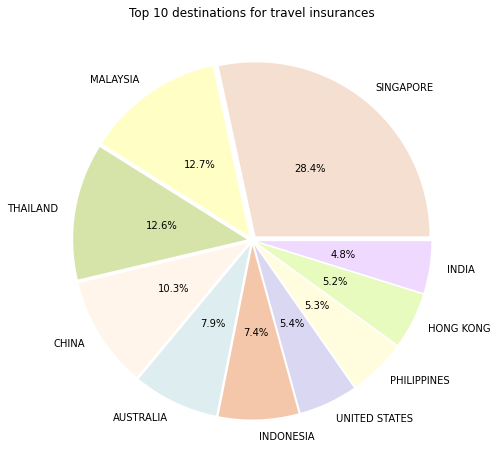

In [19]:
destination = spark.sql("SELECT Destination, COUNT(*) as Number_of_insurances FROM travel_insurance GROUP BY Destination SORT BY Number_of_insurances DESC")
destination.show()
destination = destination.toPandas().head(10)
plt.figure(figsize=(10, 8))
labels = destination['Destination']
plt.pie(x=destination['Number_of_insurances'], autopct="%.1f%%", explode=[0.03]*10, labels=labels, pctdistance=0.5, colors=['#F4DFD0', '#FFFFC5', '#D6E4AA', '#FFF5EB', '#DEEDF0', '#F4C7AB', '#D9D7F1', '#FFFDDE', '#E7FBBE', '#F0D9FF'])
plt.title('Top 10 destinations for travel insurances')
plt.show()

## Analiza valorilor numerice

### Duration

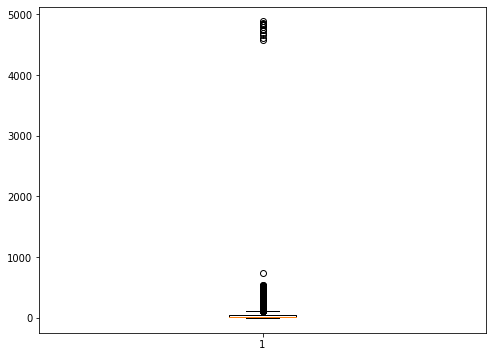

In [20]:
plt.figure(figsize=(8, 6))
plt.boxplot(data_plot['Duration'])
plt.show()

Se observa ca exista o serie de valori <= 0, pe care le vom elimina, deoarece durata nu poate fi negativa.

In [21]:
print("Old number of rows: " + str(data.count()))
data = data.where(data['Duration'] > 0)
print("New number of rows: " + str(data.count()))

Old number of rows: 63326
New number of rows: 63260


###Net Sales

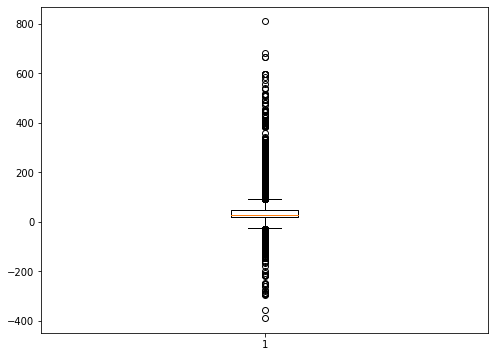

In [22]:
plt.figure(figsize=(8, 6))
plt.boxplot(data_plot['Net_Sales'])
plt.show()

### Commission

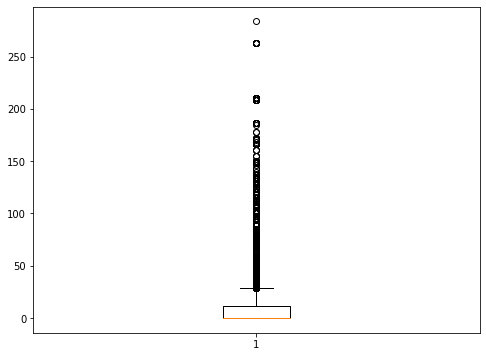

In [23]:
plt.figure(figsize=(8, 6))
plt.boxplot(data_plot['Commission'])
plt.show()

Se observa ca exista o serie de outliers pentru valori ale comisionului mai mari de 250, astfel ca ii vom elimina:

In [24]:
print("Before removing commission outliers: " + str(data.count()))
data = data.where(data['Commission'] < 250)
print("After removing commission outliers: " + str(data.count()))

Before removing commission outliers: 63260
After removing commission outliers: 63251


###Age

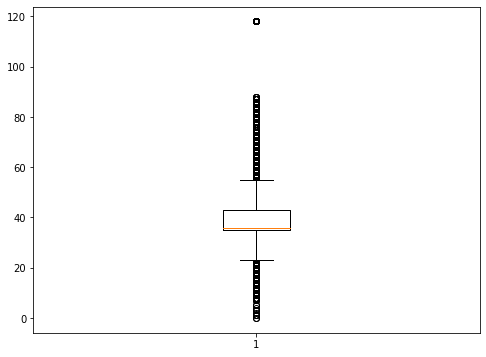

In [25]:
plt.figure(figsize=(8, 6))
plt.boxplot(data_plot['Age'])
plt.show()

De asemenea, vom construi histogramele pentru toate valorile numerice din dataset, pentru a vedea daca acestea urmeaza o anumita distributie.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f89267610>,
      dtype=object)

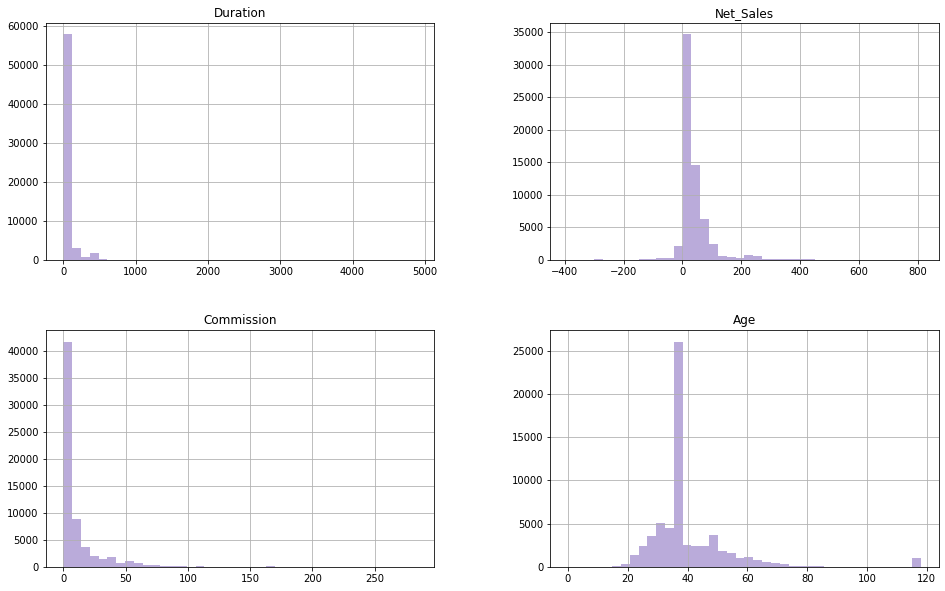

In [26]:
data_plot.hist(bins=40, figsize=(16, 10), color='#BAABDA')


### Explorarea relatiilor dintre variabilele numerice

Aceasta se va realiza prin trasarea unui *pairplot* cu ajutorul librariei *seaborn*.

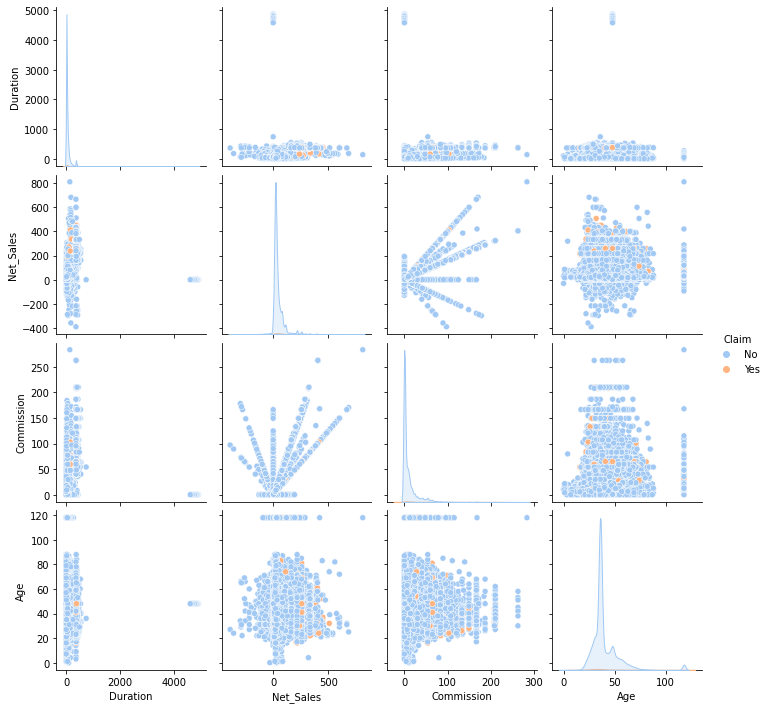

In [27]:
sns.pairplot(data_plot, hue='Claim', palette='pastel')


Se observa ca nu exista variabile numerice puternic corelate, astfel ca le vom pastra pe toate in antrenarea modelului.

# Transformarea caracteristicilor

In urma analizei datelor, s-a putut observa cum coloana target *Claim* este de tipul string, astfel ca vom inlocui cu valorile numerice 1, corespunzator lui "Yes", respectiv 0, corespunzator lui "No".

In [28]:
from pyspark.sql.functions import when
data = data.withColumn("Claim", when(data['Claim'] == "Yes", 1).when(data['Claim'] == "No", 0))

Utilizam Oversampling pentru a echilibra datele. Ideea este de a duplica datele din clasa cu mai putine intrari, pana cand atinge nivelul clasei dominante.

In [29]:
major_data = data.filter("Claim == 0")
minor_data = data.filter("Claim == 1")
ratio = int(major_data.count()/minor_data.count())
print("major data: {}, minor data: {}, ratio: {}".format(major_data.count(), minor_data.count(), ratio))

major data: 62324, minor data: 927, ratio: 67


In [30]:
from pyspark.sql.functions import explode, array, lit
a = range(ratio)

oversampled_data = minor_data.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
data = major_data.unionAll(oversampled_data)
major_data = data.filter("Claim == 0")
minor_data = data.filter("Claim == 1")
print("major data: {}, minor data: {}".format(major_data.count(), minor_data.count()))

major data: 62324, minor data: 62109


Impartim datele, 70% devenind date de antrenare, in timp de 30% sunt pastrate ca date de testare.

In [31]:
(train_data, test_data) = data.randomSplit([0.7, 0.3])


Vom aplica o serie de transformari asupra campurilor de tip string, precum *StringIndexer* si *OneHotEncoder*. Acesti algoritmi vor fi aplicati asupra coloanelor *Agency*, *Agency Type*, *Distribution Channel*, *Product Name* si *Destination* si vor face parte din acelasi pipeline.

In [32]:
from pyspark.ml.feature import StringIndexer

pipeline_stages = []
tensorflow_pipeline_stages = []
stringColumns = ['Agency', 'Agency_Type', 'Distribution_Channel', 'Product_Name', 'Destination']
for col in stringColumns:
  stringIndexer = StringIndexer(inputCol = col, outputCol = col + '_Index', handleInvalid='keep')
  pipeline_stages += [stringIndexer]
  tensorflow_pipeline_stages += [stringIndexer]

In [33]:
from pyspark.ml.feature import OneHotEncoder

stringColumns = ['Agency', 'Agency_Type', 'Distribution_Channel', 'Product_Name', 'Destination']
for col in stringColumns:
  ohe = OneHotEncoder(inputCol = col + '_Index', outputCol = col + '_OHE', handleInvalid='keep')
  pipeline_stages += [ohe]

In [34]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler

stringColumns = ['Duration', 'Net_Sales', 'Commission', 'Age']
for col in stringColumns:
  assembler = VectorAssembler(inputCols=[col], outputCol=col + '_vec')
  pipeline_stages += [assembler]
  mmScaler = MinMaxScaler(inputCol = col + '_vec', outputCol = col + '_Scaled')
  pipeline_stages += [mmScaler]

In [35]:
from pyspark.ml.feature import VectorAssembler

# Se specifica coloanele de intrare si iesire ale asamblorului de vectori
assembler = VectorAssembler(inputCols=['Agency_OHE',
                                      'Agency_Type_OHE',
                                      'Distribution_Channel_OHE',
                                      'Product_Name_OHE',
                                      'Duration_Scaled',
                                      'Destination_OHE',
                                      'Net_Sales_Scaled',
                                      'Commission_Scaled',
                                      'Age_Scaled'],
                              outputCol='features', handleInvalid='keep')

pipeline_stages += [assembler]


In [36]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = pipeline_stages)
pipelineModel = pipeline.fit(train_data)
train_data = pipelineModel.transform(train_data)
test_data = pipelineModel.transform(test_data)

In [37]:
from pyspark.sql.functions import when, lit
train_data = train_data.withColumn("weight", when((train_data['Claim'] == 0), lit(0.1)).otherwise(lit(0.9)))
test_data = test_data.withColumn("weight", when((test_data['Claim'] == 0), lit(0.1)).otherwise(lit(0.9)))

In ceea ce priveste adresarea problemelor datelor nebalansate, s-au analizat 3 metode:
1. Antrenarea datelor pe setul original
2. Antrenarea datelor adaugand coloana weight, ce poate fi folosita la regresie logistica. Aceasta influenteaza importanta datelor considerate, cele aflate in categoria cu un numar mai mic avand un weight mai mare
3. Utilizarea Oversampling-ului - duplicarea datelor din categoria cu mai putine date pentru a construi categorii de marime egala.

Dintre cele 3 metode, cea care a dat performantele cele mai mari a fost oversampling-ul, fiind metoda utilizata in continuare in notebook.

1. *Oversample*: 
    *   Area under ROC train: 0.8426
    *   Area under ROC test: 0.8321
    *   F1 score: 0.74
2. *Weight*:
    *   Area under ROC train: 0.8364
    *   Area under ROC test: 0.7992
    *   F1 score: 0.15
3. *Raw data*: 
    *   Area under ROC train: 0.8361
    *   Area under ROC test: 0.7966
    *   F1 score: 0.09

Deoarece setul de date este in continuare nebalansat cu un raport foarte mare, orice metoda care incearca sa rezolve problema pastrand numarul de date initial, desi valoarea ROC va fi mare, in realitate F1 score este mic, deoarece exista foarte putine date cu valoarea *Claim=1*, astfel ca modelul nu va invata bine, iar numarul de valori TP va fi mult mai mic decat TN.


##Antrenarea modelelor pe setul de date

S-au analizat 6 modele de clasificare - *Logistic Regression*, *SVM*, *Naive Bayes*, *Decision Tree*, *Random Forest* si *KNN* -  antrenate si testate pe setul de date, dintre care le-am ales pe cele mai performante 4. Dintre acestea s-au remarcat arborii de decizie, cu un scor F1 de 0.97, impreuna cu regresia logistica, cu un scor F1 de peste 0.76.

### Logistic Regression

In [75]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression(featuresCol = 'features', labelCol = 'Claim')


#Create ParamGrid for Cross Validation
lrParamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0, 0.001, 0.01, 0.1, 0.5, 1.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])
             .addGrid(lr.maxIter, [5, 10, 20, 50])
             .build())


lrEvaluator = BinaryClassificationEvaluator(labelCol="Claim")

# Create 5-fold CrossValidator
lrcv = CrossValidator(estimator = lr,
                    estimatorParamMaps = lrParamGrid,
                    evaluator = lrEvaluator,
                    numFolds = 5)

lrModel = lrcv.fit(train_data)

RegParam: 0.0
ElasticNetParam: 0.5
MaxIter: 50


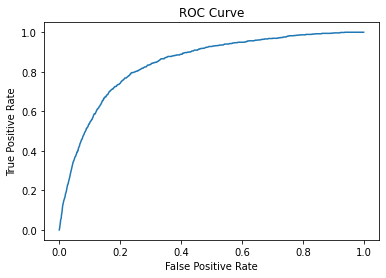

Training set areaUnderROC: 0.8434804789085449


In [98]:
trainingSummary = lrModel.bestModel.summary
print("RegParam: " + str(lrModel.bestModel._java_obj.getRegParam()))
print("ElasticNetParam: " + str(lrModel.bestModel._java_obj.getElasticNetParam()))
print("MaxIter: " + str(lrModel.bestModel._java_obj.getMaxIter()))

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [99]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

Test Area Under ROC 0.843647994100504
Precision: 0.789
Recall: 0.751
F1 score: 0.769


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


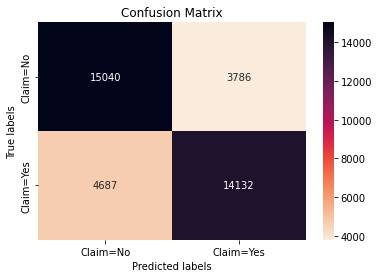

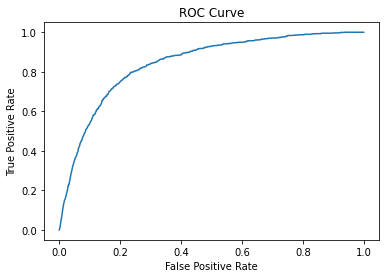

In [100]:
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score

lrPredictions = lrModel.transform(test_data)
lrPredictions.head()

evaluator = BinaryClassificationEvaluator(labelCol="Claim")
print('Test Area Under ROC', evaluator.evaluate(lrPredictions))

y_true = lrPredictions.select("Claim").toPandas()
y_pred = lrPredictions.select("prediction").toPandas()

print('Precision: %.3f' % precision_score(y_true, y_pred))
print('Recall: %.3f' % recall_score(y_true, y_pred))
print('F1 score: %.3f' % f1_score(y_true, y_pred))

cnf_matrix = confusion_matrix(y_true, y_pred)
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax, cmap=sns.cm.rocket_r)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Claim=No', 'Claim=Yes'])
ax.yaxis.set_ticklabels(['Claim=No', 'Claim=Yes'])

# Returns as a list (false positive rate, true positive rate)
preds = lrPredictions.select('Claim','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['Claim'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)
plt.show()


### Decision Tree

In [101]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="Claim", featuresCol="features")

# Create ParamGrid for Cross Validation
dtParamGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [5, 10, 20, 30])
             .build())

dtEvaluator = BinaryClassificationEvaluator(labelCol = 'Claim')

dtcv = CrossValidator(estimator = dt,
                    estimatorParamMaps = dtParamGrid,
                    evaluator = dtEvaluator,
                    numFolds = 5)

dtModel = dtcv.fit(train_data)

In [104]:
print("Max depth: " + str(dtModel.bestModel._java_obj.getMaxDepth()))

Max depth: 30


Test Area Under ROC 0.9770773141580723
Precision: 0.962
Recall: 1.000
F1 score: 0.981


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


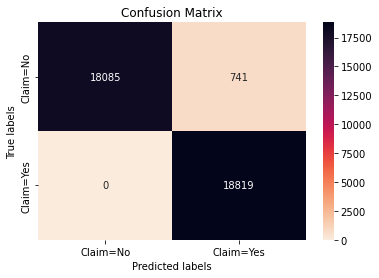

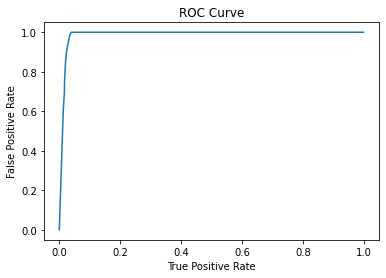

In [105]:
dtPredictions = dtModel.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol="Claim")
print('Test Area Under ROC', evaluator.evaluate(dtPredictions))

y_true = dtPredictions.select("Claim").toPandas()
y_pred = dtPredictions.select("prediction").toPandas()

print('Precision: %.3f' % precision_score(y_true, y_pred))
print('Recall: %.3f' % recall_score(y_true, y_pred))
print('F1 score: %.3f' % f1_score(y_true, y_pred))

cnf_matrix = confusion_matrix(y_true, y_pred)
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax, cmap=sns.cm.rocket_r)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Claim=No', 'Claim=Yes'])
ax.yaxis.set_ticklabels(['Claim=No', 'Claim=Yes'])

# Returns as a list (false positive rate, true positive rate)
preds = dtPredictions.select('Claim','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['Claim'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC Curve')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.plot(x_val, y_val)
plt.show()

### SVM

In [106]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

svm = LinearSVC(featuresCol = 'features', labelCol = 'Claim')

# Create ParamGrid for Cross Validation
svmParamGrid = (ParamGridBuilder()
             .addGrid(svm.regParam, [0, 0.001, 0.01, 0.1, 0.5, 1.0])
             .addGrid(svm.maxIter, [5, 10, 20, 50])
             .build())


# Evaluate model
svmEvaluator = BinaryClassificationEvaluator(labelCol = 'Claim')

# Create 3-fold CrossValidator
svmcv = CrossValidator(estimator = svm,
                    estimatorParamMaps = svmParamGrid,
                    evaluator = svmEvaluator,
                    numFolds = 5)

svmModel = svmcv.fit(train_data)

In [107]:
from matplotlib import pyplot as plt
trainingSummary = svmModel.bestModel.summary
print("RegParam: " + str(svmModel.bestModel._java_obj.getRegParam()))
print("MaxIter: " + str(svmModel.bestModel._java_obj.getMaxIter()))

RegParam: 0.001
MaxIter: 20


Test Area Under ROC 0.834939331613358
Precision: 0.808
Recall: 0.673
F1 score: 0.735


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


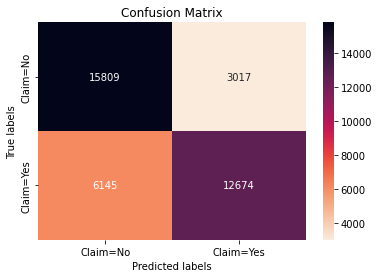

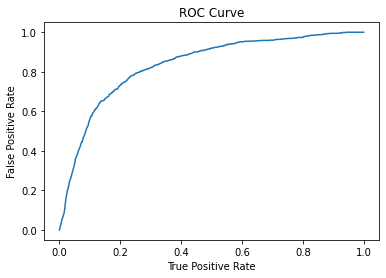

In [108]:
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score

svmPredictions = svmModel.transform(test_data)
# if 'rawPrediction' in svmPredictions.columns:
#   svmPredictions = svmPredictions.withColumnRenamed("rawPrediction","predictions")
evaluator = BinaryClassificationEvaluator(labelCol="Claim")
print('Test Area Under ROC', evaluator.evaluate(svmPredictions))

y_true = svmPredictions.select("Claim").toPandas()
y_pred = svmPredictions.select("prediction").toPandas()

print('Precision: %.3f' % precision_score(y_true, y_pred))
print('Recall: %.3f' % recall_score(y_true, y_pred))
print('F1 score: %.3f' % f1_score(y_true, y_pred))

cnf_matrix = confusion_matrix(y_true, y_pred)
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax, cmap=sns.cm.rocket_r)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Claim=No', 'Claim=Yes'])
ax.yaxis.set_ticklabels(['Claim=No', 'Claim=Yes'])

# Returns as a list (false positive rate, true positive rate)
preds = svmPredictions.select('Claim','rawPrediction').rdd.map(lambda row: (float(row['rawPrediction'][1]), float(row['Claim'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC Curve')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.plot(x_val, y_val)
plt.show()


### Random forest 

In [109]:
from pyspark.ml.classification import RandomForestClassifier

# Antrenarea unui model RandomForest
rf = RandomForestClassifier(labelCol="Claim", featuresCol="features", numTrees=10)

# Create ParamGrid for Cross Validation
rfParamGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [5, 10, 20, 30])
             .build())

# Evaluate model
rfEvaluator = BinaryClassificationEvaluator(labelCol = 'Claim')

# Create 5-fold CrossValidator
rfcv = CrossValidator(estimator = rf,
                    estimatorParamMaps = rfParamGrid,
                    evaluator = rfEvaluator,
                    numFolds = 5)

rfModel = rfcv.fit(train_data)

In [110]:
from matplotlib import pyplot as plt
print("Max depth: " + str(rfModel.bestModel._java_obj.getMaxDepth()))

Max depth: 5


Test Area Under ROC 0.8214502088809514
Precision: 0.821
Recall: 0.620
F1 score: 0.707


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


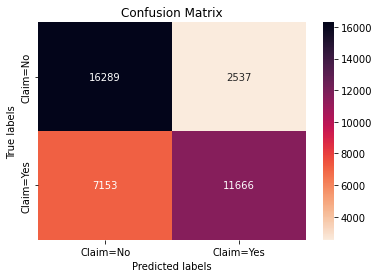

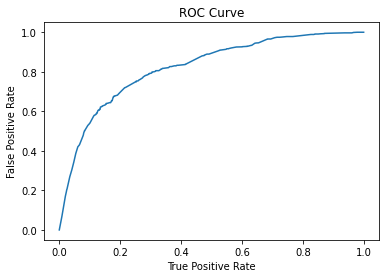

In [111]:
rfPredictions = rfModel.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol="Claim")
print('Test Area Under ROC', evaluator.evaluate(rfPredictions))

y_true = rfPredictions.select("Claim").toPandas()
y_pred = rfPredictions.select("prediction").toPandas()

print('Precision: %.3f' % precision_score(y_true, y_pred))
print('Recall: %.3f' % recall_score(y_true, y_pred))
print('F1 score: %.3f' % f1_score(y_true, y_pred))

cnf_matrix = confusion_matrix(y_true, y_pred)
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax, cmap=sns.cm.rocket_r)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Claim=No', 'Claim=Yes'])
ax.yaxis.set_ticklabels(['Claim=No', 'Claim=Yes'])

# Returns as a list (false positive rate, true positive rate)
preds = rfPredictions.select('Claim','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['Claim'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC Curve')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.plot(x_val, y_val)
plt.show()


# TensorFlow

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

In [46]:
pipeline = Pipeline(stages = tensorflow_pipeline_stages)
pipelineModel = pipeline.fit(data)
data_processed = pipelineModel.transform(data)

In [47]:
data_processed.head()

Row(Agency='CBH', Agency_Type='Travel Agency', Distribution_Channel='Offline', Product_Name='Comprehensive Plan', Claim=0, Duration=186, Destination='MALAYSIA', Net_Sales=-29.0, Commission=9.57, Age=81, Agency_Index=13.0, Agency_Type_Index=0.0, Distribution_Channel_Index=1.0, Product_Name_Index=14.0, Destination_Index=3.0)

In [48]:
data_pd = data_processed.select('Agency_Index', 'Agency_Type_Index', 'Distribution_Channel_Index', 'Product_Name_Index', 'Claim', 'Duration', 'Destination_Index', 'Net_Sales', 'Commission', 'Age').toPandas()
x = data_pd.drop('Claim', axis=1)
y = data_pd['Claim']

Construim datele de test si de training, datele de test fiind formate din 25% din setul de date, luand ca seed pentru starea randomizata numarul 101.

In [49]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=101)

In [50]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler = MinMaxScaler()

x_train_std = scaler.fit_transform(x_train[['Duration', 'Net_Sales', 'Commission', 'Age']])
x_train[['Duration', 'Net_Sales', 'Commission', 'Age']] = x_train_std
x_train.head()
x_train = np.asarray(x_train)
x_test_std = scaler.transform(x_test[['Duration', 'Net_Sales', 'Commission', 'Age']])
x_test[['Duration', 'Net_Sales', 'Commission', 'Age']] = x_test_std
x_test.head()
x_test = np.asarray(x_test)


In [51]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

Construim un model de tip sequential ce va avea 4 straturi, primele trei avand functia de activare *relu*, iar ultimul strat va avea functia de activare *sigmoid*, deoarece e vorba de o problema de clasificare binara. Vom utiliza Dropout intre straturi, pentru a ignora zgomotul si a face modelul mai robust, astfel ca erorile vor fi mai reduse.

In [52]:
model = Sequential()
model.add(Dense(units=27, activation='relu', input_shape=(9,))) 
model.add(Dense(units=18, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(units=9, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid')) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 27)                270       
                                                                 
 dense_1 (Dense)             (None, 18)                504       
                                                                 
 dropout (Dropout)           (None, 18)                0         
                                                                 
 dense_2 (Dense)             (None, 9)                 171       
                                                                 
 dropout_1 (Dropout)         (None, 9)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 10        
                                                                 
Total params: 955
Trainable params: 955
Non-trainable pa

Avantajul principal la optimizorul *adam* este ca nu trebuie sa specificam learning rate-ul, deoarece e optimizat singur. Pentru ca setul de date era initial nebalansat, vom alege ca metrici alaturi de acuratete si Recall.

In [53]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', tf.keras.metrics.Recall()])

Implementam early stopping, astfel ca dupa 25 de epoci dupa care nu se va observa nicio imbunatatire, modelul va fi oprit.

In [54]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [55]:
history = model.fit(x=x_train, 
                   y=y_train, 
                   epochs=200,
                   validation_data=(x_test, y_test),
                   verbose=1,
                   callbacks=[early_stop])

Epoch 1/200
2917/2917 [==============================] - 33s 10ms/step - loss: 0.6123 - accuracy: 0.6832 - recall: 0.5684 - val_loss: 0.5386 - val_accuracy: 0.7482 - val_recall: 0.6248
Epoch 2/200
2917/2917 [==============================] - 29s 10ms/step - loss: 0.5722 - accuracy: 0.7212 - recall: 0.6137 - val_loss: 0.5253 - val_accuracy: 0.7518 - val_recall: 0.6366
Epoch 3/200
2917/2917 [==============================] - 29s 10ms/step - loss: 0.5624 - accuracy: 0.7327 - recall: 0.6838 - val_loss: 0.5243 - val_accuracy: 0.7546 - val_recall: 0.6455
Epoch 4/200
2917/2917 [==============================] - 24s 8ms/step - loss: 0.5577 - accuracy: 0.7372 - recall: 0.6999 - val_loss: 0.5193 - val_accuracy: 0.7536 - val_recall: 0.6425
Epoch 5/200
2917/2917 [==============================] - 18s 6ms/step - loss: 0.5536 - accuracy: 0.7384 - recall: 0.7066 - val_loss: 0.5097 - val_accuracy: 0.7599 - val_recall: 0.6918
Epoch 6/200
2917/2917 [==============================] - 17s 6ms/step - loss:

Text(0, 0.5, 'loss')

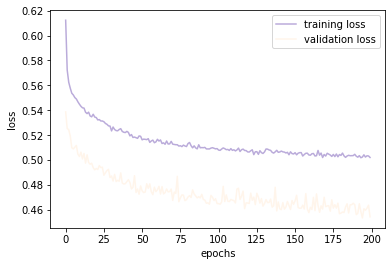

In [56]:
plt.plot(history.history['loss'], c='#BAABDA', label='training loss')
plt.plot(history.history['val_loss'], c='#FFF5EB', label='validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

In [57]:
from sklearn.metrics import classification_report

y_pred = (model.predict(x_test) > 0.5).reshape((-1,))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.73      0.78     15591
           1       0.76      0.84      0.80     15518

    accuracy                           0.79     31109
   macro avg       0.79      0.79      0.79     31109
weighted avg       0.79      0.79      0.79     31109



# Spark Streaming

Am incercat transmiterea datelor din fisier incarcate anterior printr-o topica de Kafka. Am inceput cu importurile necesare.



In [58]:
!pip install kafka-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
import os
from datetime import datetime
import time
import threading
import json
from kafka import KafkaProducer
from kafka.errors import KafkaError

In [60]:
!curl -sSOL https://dlcdn.apache.org/kafka/3.1.0/kafka_2.13-3.1.0.tgz
!tar -xzf kafka_2.13-3.1.0.tgz

In [61]:
!./kafka_2.13-3.1.0/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-3.1.0/config/zookeeper.properties
!./kafka_2.13-3.1.0/bin/kafka-server-start.sh -daemon ./kafka_2.13-3.1.0/config/server.properties
!echo "Waiting for 10 secs until kafka and zookeeper services are up and running"
!sleep 10

Waiting for 10 secs until kafka and zookeeper services are up and running


In [62]:
!ps -ef | grep kafka

root        9632       1  0 11:58 ?        00:00:10 java -Xmx512M -Xms512M -server -XX:+UseG1GC -XX:MaxGCPauseMillis=20 -XX:InitiatingHeapOccupancyPercent=35 -XX:+ExplicitGCInvokesConcurrent -XX:MaxInlineLevel=15 -Djava.awt.headless=true -Xlog:gc*:file=/content/kafka_2.13-3.1.0/bin/../logs/zookeeper-gc.log:time,tags:filecount=10,filesize=100M -Dcom.sun.management.jmxremote -Dcom.sun.management.jmxremote.authenticate=false -Dcom.sun.management.jmxremote.ssl=false -Dkafka.logs.dir=/content/kafka_2.13-3.1.0/bin/../logs -Dlog4j.configuration=file:./kafka_2.13-3.1.0/bin/../config/log4j.properties -cp /content/kafka_2.13-3.1.0/bin/../libs/activation-1.1.1.jar:/content/kafka_2.13-3.1.0/bin/../libs/aopalliance-repackaged-2.6.1.jar:/content/kafka_2.13-3.1.0/bin/../libs/argparse4j-0.7.0.jar:/content/kafka_2.13-3.1.0/bin/../libs/audience-annotations-0.5.0.jar:/content/kafka_2.13-3.1.0/bin/../libs/commons-cli-1.4.jar:/content/kafka_2.13-3.1.0/bin/../libs/commons-lang3-3.8.1.jar:/content/kafka_2.13

Am creat doua topice de kafka, una numita *insurance-train*, iar alta numita *insurance-test*.


In [63]:
!./kafka_2.13-3.1.0/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic insurance-train
!./kafka_2.13-3.1.0/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 2 --topic insurance-test

Error while executing topic command : Topic 'insurance-train' already exists.
[2022-06-22 13:47:29,223] ERROR org.apache.kafka.common.errors.TopicExistsException: Topic 'insurance-train' already exists.
 (kafka.admin.TopicCommand$)
Error while executing topic command : Topic 'insurance-test' already exists.
[2022-06-22 13:47:36,586] ERROR org.apache.kafka.common.errors.TopicExistsException: Topic 'insurance-test' already exists.
 (kafka.admin.TopicCommand$)


In [64]:
!./kafka_2.13-3.1.0/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic insurance-train
!./kafka_2.13-3.1.0/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic insurance-test

Topic: insurance-train	TopicId: EV4QIzJyS-mjzkpKZPnPJw	PartitionCount: 1	ReplicationFactor: 1	Configs: segment.bytes=1073741824
	Topic: insurance-train	Partition: 0	Leader: 0	Replicas: 0	Isr: 0
Topic: insurance-test	TopicId: UJ6V3qegQRS2C3Ck4aixhQ	PartitionCount: 2	ReplicationFactor: 1	Configs: segment.bytes=1073741824
	Topic: insurance-test	Partition: 0	Leader: 0	Replicas: 0	Isr: 0
	Topic: insurance-test	Partition: 1	Leader: 0	Replicas: 0	Isr: 0


In [65]:
from sklearn.model_selection import train_test_split
x = data.toPandas().drop('Claim', axis=1)
y = data.toPandas()['Claim']
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(x, y, test_size=0.25, random_state=101)

In [66]:
x_train = list(filter(None, x_train_df.to_csv(index=False).split("\n")[1:]))
y_train = list(filter(None, y_train_df.to_csv(index=False).split("\n")[1:]))

x_test = list(filter(None, x_test_df.to_csv(index=False).split("\n")[1:]))
y_test = list(filter(None, y_test_df.to_csv(index=False).split("\n")[1:]))

In [68]:
NUM_COLUMNS = len(x_train_df.columns)
len(x_train), len(y_train), len(x_test), len(y_test)

(93324, 93324, 31109, 31109)

Scriem datele in topicurile de kafka. Acestea vor fi trimise la 127.0.0.1:9092.

In [67]:
def error_callback(exc):
    raise Exception('Error while sendig data to kafka: {0}'.format(str(exc)))

def write_to_kafka(topic_name, items):
  count=0
  producer = KafkaProducer(bootstrap_servers=['127.0.0.1:9092'])
  for message, key in items:
    producer.send(topic_name, key=key.encode('utf-8'), value=message.encode('utf-8')).add_errback(error_callback)
    count+=1
  producer.flush()
  print("Wrote {0} messages into topic: {1}".format(count, topic_name))

write_to_kafka("insurance-train", zip(x_train, y_train))
write_to_kafka("insurance-test", zip(x_test, y_test))

Wrote 93324 messages into topic: insurance-train
Wrote 31109 messages into topic: insurance-test


In [112]:
!wget "https://repo1.maven.org/maven2/org/apache/spark/spark-streaming-kafka-0-10-assembly_2.13/3.1.0/spark-streaming-kafka-0-10-assembly_2.13-3.1.0-sources.jar"

--2022-06-22 16:18:01--  https://repo1.maven.org/maven2/org/apache/spark/spark-streaming-kafka-0-10-assembly_2.13/3.1.0/spark-streaming-kafka-0-10-assembly_2.13-3.1.0-sources.jar
Resolving repo1.maven.org (repo1.maven.org)... 199.232.192.209, 199.232.196.209
Connecting to repo1.maven.org (repo1.maven.org)|199.232.192.209|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-06-22 16:18:01 ERROR 404: Not Found.



In [113]:
import os

# os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /content/spark-streaming-kafka-0-10-assembly_2.13-3.1.0-sources.jar pyspark-shell'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.0'


In [87]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [96]:
import findspark
findspark.init()


In [93]:
kafka_topic_name = "insurance-train"
kafka_bootstrap_servers = 'localhost:9092'

In [71]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext

sc = spark.sparkContext
ssc = StreamingContext(sc, 5)

Citim datele cu ajutorul lui readStream construind un subscriber atasat topicului definit anterior. Din pacate, urmatoarele celule de cod nu functioneaza din cauza problemelor de versiune.

In [ ]:
# Subscribe to 1 topic
df = spark.readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", kafka_bootstrap_servers) \
  .option("subscribe", kafka_topic_name) \
  .load()
  
df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

In [ ]:
lines = df.map(lambda x: x[1])
counts = lines.flatMap(lambda line: line.split(' '))
counts = lines.flatMap(lambda line: line.split(' ')).map(lambda word: (word, 1)).reduceByKey(lambda a, b: a+b)
counts.pprint()
ssc.start()
# stream will run for 50 sec
ssc.awaitTerminationOrTimeout(50)
ssc.stop()
sc.stop()